## Questions for Professors
* how can we transform our landmark coordinates?

In [8]:
import SimpleITK as sitk
import os
import numpy as np

# Utility method that either downloads data from the MIDAS repository or
# if already downloaded returns the file name for reading from disk (cached data).
# %run update_path_to_download_script
# from downloaddata import fetch_data as fdata

# Always write output to a separate directory, we don't want to pollute the source directory. 
OUTPUT_DIR = 'Output'

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, fixed, Layout
from IPython.display import clear_output

plt.rcParams['figure.figsize'] = [8, 8]

# max intensity value to consider for the plot
max_value = -27_000

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # scale to [0, 255] in oder to show the image
    moving_npa = np.copy(moving_npa)
    fixed_npa = np.copy(fixed_npa)
    moving_npa[moving_npa > max_value] = max_value
    fixed_npa[fixed_npa > max_value] = max_value

    moving_npa = 255 * (moving_npa - moving_npa.min()) / (moving_npa.max() - moving_npa.min())
    fixed_npa = 255 * (fixed_npa - fixed_npa.min()) / (fixed_npa.max() - fixed_npa.min())
    
    print(type(moving_npa))
    print(fixed_npa.min())
    print(fixed_npa.max())
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    
    img = np.copy(sitk.GetArrayViewFromImage(img))
    img[img > max_value] = max_value

    img = 255 * (img - img.min()) / (img.max() - img.min())
    plt.imshow(img,cmap=plt.cm.Greys_r, interpolation='bilinear');
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [10]:
# Set path to test files and import
chosen_im = 'copd2'

# Set path to data folder containing copd1, copd2, etc. folders
data_dir = "../data"

path_img1 = os.path.join(data_dir, f'./{chosen_im}/{chosen_im}_eBHCT.mha')
path_img2 = os.path.join(data_dir, f'./{chosen_im}/{chosen_im}_iBHCT.mha')

In [11]:
fixed_image =  sitk.ReadImage(path_img1, sitk.sitkFloat32)
moving_image = sitk.ReadImage(path_img2, sitk.sitkFloat32) 

interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1),
         moving_image_z=(0,moving_image.GetSize()[2]-1),
         fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)),
         moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

interactive(children=(IntSlider(value=50, description='fixed_image_z', max=101), IntSlider(value=50, description='moving_image_z', max=101), Output()), _dom_classes=('widget-interact',))

In [12]:
# intial transform
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha,
         image_z=(0,fixed_image.GetSize()[2]),
         alpha=(0.0,1.0,0.05),
         fixed=fixed(fixed_image),
         moving=fixed(moving_resampled));


interactive(children=(IntSlider(value=51, description='image_z', max=102), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

In [13]:
print(initial_transform)

itk::simple::Transform
 Euler3DTransform (0x558564241dd0)
   RTTI typeinfo:   itk::Euler3DTransform<double>
   Reference Count: 1
   Modified Time: 3050
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 0 0 
     0 1 0 
     0 0 1 
   Offset: [0, 0, 0]
   Center: [163.52, 163.52, -126.25]
   Translation: [0, 0, 0]
   Inverse: 
     1 0 0 
     0 1 0 
     0 0 1 
   Singular: 0
   Euler's angles: AngleX=0 AngleY=0 AngleZ=0
   m_ComputeZYX = 0



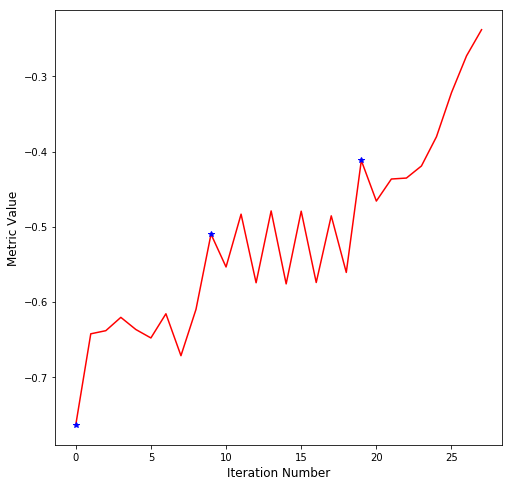

In [83]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
#registration_method.SetMetricAsCorrelation() # -1 - perfect fit
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [84]:
print(final_transform)

itk::simple::Transform
 CompositeTransform (0x5640a8a444f0)
   RTTI typeinfo:   itk::CompositeTransform<double, 3u>
   Reference Count: 1
   Modified Time: 3747211
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0x5640a9e30a00)
     RTTI typeinfo:   itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 3746957
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.999998 2.08078e-05 -0.00195872 
       -4.96396e-06 0.999967 0.00808854 
       0.00195882 -0.00808851 0.999965 
     Offset: [-3.24407, 17.7778, 1.19229]
     Center: [163.52, 163.52, -126.25]
     Translation: [-2.9937, 16.7505, 0.194335]
     Inverse: 
       0.999998 -4.96396e-06 0.00195882 
       2.08078e-05 0.999967 -0.00808851 
       -0.00195872 0.00808854 0.999965 
     Singular: 0
     Euler's angles: AngleX=-0.0080886 AngleY=-0.00195888 AngleZ=-2.08085e-05
     m_ComputeZYX = 0
 

In [77]:
help(registration_method)

Help on ImageRegistrationMethod in module SimpleITK.SimpleITK object:

class ImageRegistrationMethod(ProcessObject)
 |  An interface method to the modular ITKv4 registration framework.
 |  
 |  
 |  This interface method class encapsulates typical registration usage by
 |  incorporating all the necessary elements for performing a simple image
 |  registration between two images. This method also allows for
 |  multistage registration whereby each stage is characterized by
 |  possibly different transforms and different image metrics. For
 |  example, many users will want to perform a linear registration
 |  followed by deformable registration where both stages are performed in
 |  multiple levels. Each level can be characterized by:
 |  
 |  
 |  the resolution of the virtual domain image (see below)
 |  
 |  smoothing of the fixed and moving images
 |   Multiple stages are handled by linking multiple instantiations of
 |  this class where the output transform is added to the optional


In [85]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=51, description='image_z', max=102), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

## Try B-Splines

In [ ]:
def command_iteration(method) :
    if (method.GetOptimizerIteration()==0):
        print("Scales: ", method.GetOptimizerScales())
    print("{0:3} = {1:7.5f} : {2}".format(method.GetOptimizerIteration(),
                                           method.GetMetricValue(),
                                           method.GetOptimizerPosition()))


transformDomainMeshSize=[8]*moving_resampled.GetDimension()
tx = sitk.BSplineTransformInitializer(sitk.Cast(fixed_image, sitk.sitkFloat32),
                                      transformDomainMeshSize )

print("Initial Parameters:", tx.GetParameters());

R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()

R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5,
                       numberOfIterations=100,
                       maximumNumberOfCorrections=5,
                       maximumNumberOfFunctionEvaluations=1000,
                       costFunctionConvergenceFactor=1e+7)
R.SetInitialTransform(tx, True)
R.SetInterpolator(sitk.sitkLinear)

R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )

outTx = R.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                  sitk.Cast(moving_resampled, sitk.sitkFloat32))

print("-------")
print(outTx)
print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(R.GetOptimizerIteration()))
print(" Metric value: {0}".format(R.GetMetricValue()))

Initial Parameters: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,